In [1]:
%load_ext autoreload
%autoreload 2

## Imports, top level definitions and data loading

In [4]:
import keras_lmu
import pandas as pd
import os
import tensorflow as tf
import numpy as np

from core.pre_processing import build_ohio_dataset, build_windows, get_patient_window
from core.utils import compile_and_fit, plot_loss

In [6]:
# Path where to store the trained models
root_path = "models"

SAMPL_FREQ = 5

PATIENTS_2018 = ["559", "563", "570", "575", "588", "591"]
PATIENTS_2020 = ["540", "544", "552", "567", "584", "596"]

model_name = "lmu_2020_ph30min"

In [8]:
dataset_all_2018_full = build_ohio_dataset("all", pretrain_on_2018_train_only=False)

Using time to peak: 100 for patient 559
Identified 42 gaps for train set of 559
Identified 11 gaps for val set of 559
Identified 0 gaps for test set of 559
Using time to peak: 100 for patient 563
Identified 21 gaps for train set of 563
Identified 3 gaps for val set of 563
Identified 0 gaps for test set of 563
Using time to peak: 100 for patient 570
Identified 20 gaps for train set of 570
Identified 9 gaps for val set of 570
Identified 0 gaps for test set of 570
Using time to peak: 100 for patient 575
Identified 68 gaps for train set of 575
Identified 14 gaps for val set of 575
Identified 0 gaps for test set of 575
Using time to peak: 100 for patient 588
Identified 10 gaps for train set of 588
Identified 2 gaps for val set of 588
Identified 0 gaps for test set of 588
Using time to peak: 100 for patient 591
Identified 26 gaps for train set of 591
Identified 4 gaps for val set of 591
Identified 0 gaps for test set of 591
Using time to peak: 100 for patient 540
Identified 22 gaps for train

## Setup params for the model and input

In [9]:
# 6 steps -> 30 minutes prediction horizon
PH = 6
batch_size = 256

# 30 minutes of input
input_len = 30

features = ["Time", "Glucose", "Rapid Insulin sub_tissue", "Carbohydrates gut", "finger_stick"]

## Create pre-processed input-target pairs for the model
Additionally create input-target pairs per each patient so that we can evaluate the performance individually per patient

In [10]:
w_2020, _ = build_windows(dataset_all_2018_full, features, input_len // SAMPL_FREQ, 1, PH, drop_noisy=False, batch_size=batch_size, min_max_scale=False)

In [11]:
patient_windows_2020 = {}
for p_tr_df, p_v_df, p_tst_df, patient_id in dataset_all_2018_full:
    if patient_id not in PATIENTS_2020:
        continue
    patient_windows_2020[patient_id] = get_patient_window(
        (p_tr_df, p_v_df, p_tst_df),
        features,
        input_len // SAMPL_FREQ,
        1,
        PH,
        drop_noisy=False,
        batch_size=batch_size,
        min_max_scale=False
    )

In [12]:
len(patient_windows_2020)

6

## Train and evaluate models

In [18]:
def train_model(patient_windows, model_name: str, train_window):
    lmu_layer = keras_lmu.LMU(
        memory_d=4,
        order=60,
        theta=input_len // SAMPL_FREQ,
        hidden_to_memory=True,
        memory_to_memory=False,
        input_to_hidden=False,
        hidden_cell=tf.keras.layers.LSTMCell(units=72),
        return_sequences=False,
        dropout=0.1,
        recurrent_dropout=0.2,
    )
    inputs = tf.keras.Input((input_len // SAMPL_FREQ, 4))
    lmus = lmu_layer(inputs)
    outputs = tf.keras.layers.Dense(1)(lmus)
    output_plus_input = tf.keras.layers.Add()([outputs, inputs[:, -1, 0]])

    model = tf.keras.Model(inputs=inputs, outputs=output_plus_input)
    print(model.summary())

    history = compile_and_fit(model, train_window, max_epochs=300, learning_rate=10**-3, patience=35, store_model=model_name)
    plot_loss(history, "Loss", False)

    best_model = tf.keras.models.load_model(os.path.join(root_path, model_name))

    results_val = []
    results_test = []

    for patient_id, patient_w in patient_windows.items():
        print("Evaluating on patient_id:", patient_id)
        val_p = best_model.evaluate(patient_w.val, verbose=0)[1]
        test_p = best_model.evaluate(patient_w.test, verbose=0)[1]
        results_val.append((model_name, patient_id, val_p))
        results_test.append((model_name, patient_id, test_p))
    return results_val, results_test

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6, 4)]               0         []                            
                                                                                                  
 lmu_1 (LMU)                 (None, 72)                   90448     ['input_2[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 1)                    73        ['lmu_1[0][0]']               
                                                                                                  
 tf.__operators__.getitem_1  (None,)                      0         ['input_2[0][0]']             
  (SlicingOpLambda)                                                                         

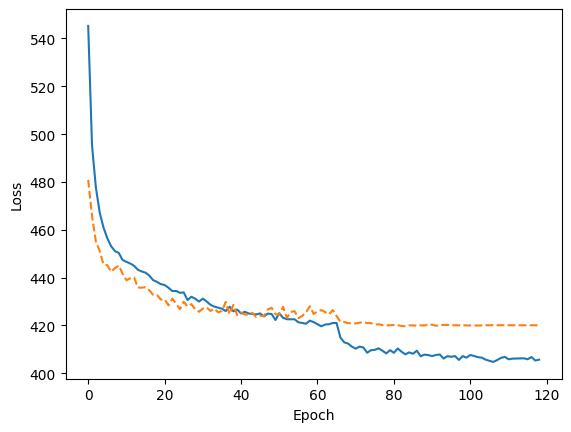

In [19]:
val_errs, test_errs = train_model(patient_windows_2020, f"{model_name}_0", w_2020)

In [23]:
print(np.average([rmse for _, _, rmse in test_errs]))

18.57125775019328


## Get statistics for multiple training runs

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 6, 4)]               0         []                            
                                                                                                  
 lmu_2 (LMU)                 (None, 72)                   90448     ['input_3[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 1)                    73        ['lmu_2[0][0]']               
                                                                                                  
 tf.__operators__.getitem_2  (None,)                      0         ['input_3[0][0]']             
  (SlicingOpLambda)                                                                         

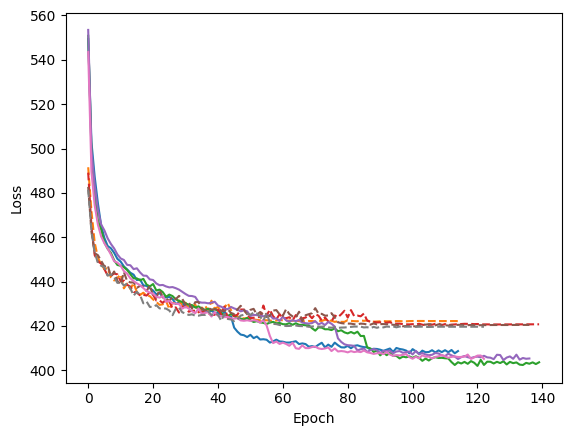

In [24]:
# 4 more runs
for i in range(1, 5):
    cur_val_errs, cur_test_errs = train_model(patient_windows_2020, f"{model_name}_{i}", w_2020)
    test_errs.extend(cur_test_errs)
    val_errs.extend(cur_val_errs)

In [25]:
test_errs

[('lmu_2020_ph30min_0', '540', 20.54216194152832),
 ('lmu_2020_ph30min_0', '544', 16.419721603393555),
 ('lmu_2020_ph30min_0', '552', 15.787924766540527),
 ('lmu_2020_ph30min_0', '567', 20.426105499267578),
 ('lmu_2020_ph30min_0', '584', 21.905719757080078),
 ('lmu_2020_ph30min_0', '596', 16.34591293334961),
 ('lmu_2020_ph30min_1', '540', 20.4735050201416),
 ('lmu_2020_ph30min_1', '544', 16.568387985229492),
 ('lmu_2020_ph30min_1', '552', 15.681341171264648),
 ('lmu_2020_ph30min_1', '567', 20.354843139648438),
 ('lmu_2020_ph30min_1', '584', 21.916000366210938),
 ('lmu_2020_ph30min_1', '596', 16.211027145385742),
 ('lmu_2020_ph30min_2', '540', 20.468116760253906),
 ('lmu_2020_ph30min_2', '544', 16.53074073791504),
 ('lmu_2020_ph30min_2', '552', 15.766265869140625),
 ('lmu_2020_ph30min_2', '567', 20.430416107177734),
 ('lmu_2020_ph30min_2', '584', 22.029109954833984),
 ('lmu_2020_ph30min_2', '596', 16.38261604309082),
 ('lmu_2020_ph30min_3', '540', 20.56362533569336),
 ('lmu_2020_ph30min

In [26]:
val_errs

[('lmu_2020_ph30min_0', '540', 20.658451080322266),
 ('lmu_2020_ph30min_0', '544', 16.395841598510742),
 ('lmu_2020_ph30min_0', '552', 20.388402938842773),
 ('lmu_2020_ph30min_0', '567', 25.101762771606445),
 ('lmu_2020_ph30min_0', '584', 34.316925048828125),
 ('lmu_2020_ph30min_0', '596', 13.138344764709473),
 ('lmu_2020_ph30min_1', '540', 20.721351623535156),
 ('lmu_2020_ph30min_1', '544', 16.501218795776367),
 ('lmu_2020_ph30min_1', '552', 20.321706771850586),
 ('lmu_2020_ph30min_1', '567', 25.17034912109375),
 ('lmu_2020_ph30min_1', '584', 34.40910720825195),
 ('lmu_2020_ph30min_1', '596', 13.186478614807129),
 ('lmu_2020_ph30min_2', '540', 20.705799102783203),
 ('lmu_2020_ph30min_2', '544', 16.382871627807617),
 ('lmu_2020_ph30min_2', '552', 20.3212833404541),
 ('lmu_2020_ph30min_2', '567', 25.126873016357422),
 ('lmu_2020_ph30min_2', '584', 34.261444091796875),
 ('lmu_2020_ph30min_2', '596', 13.214309692382812),
 ('lmu_2020_ph30min_3', '540', 20.679889678955078),
 ('lmu_2020_ph30

In [27]:
df_results_test = pd.DataFrame(test_errs, columns=['Model iteration', 'Patient ID', 'RMSE'])
df_results_test['Model'] = df_results_test['Model iteration'].str.replace(r'_\d+$', '', regex=True)

In [28]:
df_results_test.groupby(['Model iteration'])['RMSE'].agg(['mean'])

,mean
Model iteration,
lmu_2020_ph30min_0,18.571258
lmu_2020_ph30min_1,18.534184
lmu_2020_ph30min_2,18.601211
lmu_2020_ph30min_3,18.568215
lmu_2020_ph30min_4,18.534818


In [29]:
df_results_test.groupby(['Model iteration', 'Model'])['RMSE'].agg(['mean']).groupby("Model").agg(["mean", "std"])

mean          
                       mean       std
Model                                
lmu_2020_ph30min  18.561937  0.028171

In [30]:
df_results_test.groupby(['Patient ID'])['RMSE'].agg(["mean", "std"])

,mean,std
Patient ID,,
540,20.496880,0.053539
544,16.507426,0.069209
552,15.724632,0.055074
567,20.409171,0.059581
584,21.917984,0.065807
596,16.315529,0.064016
